### Introduction

In this program, we will implement the Ninomiya-Victoir approximation scheme for stochastic differential equations in order to price financial derivatives in a Heston model context, using Monte-Carlo methods


The Ninomiya-Victoir scheme is defined as follows, on the idea of scheme composition :

$Z_k = (Z^1_k, ... , Z^d_k) , Z^i_k \sim N(0,1)$

$(\Lambda_k)_{k}$ Rademacher variables, verifying :
$\mathbb{P}(\Lambda = 1 ) = \mathbb{P}(\Lambda = -1 ) = \frac{1}{2}$

$X^n_{k+1} = $ exp$(\frac{1}{2n}V_0 ) \circ $ exp$(\frac{Z^d_k}{\sqrt n}V_1 ) \circ $  ...  $  \circ $ exp$(\frac{Z^1_k}{\sqrt{n}}V_d) $ $\circ $ exp$(\frac{1}{2n}V_0 )(X^n_{k} )  $   $\textbf{ $\Lambda_k = 1$} $

$ $     = exp$(\frac{1}{2n}V_0 ) \circ $ exp$(\frac{Z^d_k}{\sqrt n}V_d ) \circ $  ...  $  \circ $ exp$(\frac{Z^1_k}{\sqrt{n}}V_1) $ $\circ $ exp$(\frac{1}{2n}V_0)(X_k^n)  $    $\textbf{ $\Lambda_k = -1$} $

The $exp(\frac{Z}{\sqrt n}V_i )$ functions are solutions to some ordinary differential equations. 

The scheme is defined by induction. To get the following value of the stochastic process we want to approximate, we -simply- have to pass the present state ($X_k^n$) in a composed function or another, depending on some Rademacher random variable

This scheme weakly converges at order 2, meaning that for greater values of $n$ (the number of steps in the scheme) its weak error converges as $\frac{C}{n^2}$. In comparaison, the Euler scheme only weakly converges at order 1

To summarize, this scheme provides us with the possibility to generate trajectories of a process which approximates in a satisfying way (in the sense of the weak error) an asset price in the Heston model context. (We could approximate any other model)

Thus, we can apply Monte-Carlo methods to price any product where the payoff at maturity can be written as a function of the quantities we approximate (here, the asset price and its volatility) until the maturity

For further details on the notations, framework, follow this link to a pdf explaining everything

https://www.linkedin.com/in/j%C3%A9r%C3%A9mie-ohana-74877a1b6/detail/overlay-view/urn:li:fsd_profileTreasuryMedia:(ACoAADJNsqgBPX6WXUQZFi98pnsnn7Pr6Qq7TRo,1635463669015)/

In [2]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# Does the Feller condition holds ?

def condition_parameters(theta, kappa, xi):
    if 2*theta*kappa - xi**2 > 0:
        print("Feller condition holds for")
        print("theta = ", theta, " kappa = ", kappa, " xi = ", xi)
        return(True)
    else:
        print("Feller condition does not hold !")
        return(False)

In [4]:
# The following function is just a helpful function to compose a bunch of functions, which we will be doing

# if reverse_order is False, we compose the functions in the usual way

def compose_functions(x,reverse_order=False,*args):
    for arg in args:
        if callable(arg):
            pass
        else:
            print(arg)
            raise Exception("One or multiple arguments is not a function")
    
    # Usual way to compose (last one first)
    if reverse_order == False:
        # We initialize y as the image of the first function of *args
        y = args[-1](x)
        
        # And then we iterate through *args
        for k in range(2,len(args)+1):
            y = args[-k](y)
        return(y)
    
    if reverse_order == True:
        # We initialize y as the image of the first function of *args
        y = args[0](x)

        # And then we iterate through *args
        for k in range(1,len(args)):
            y = args[k](y)
        return(y)

    else:
        raise Exception("Argument 'reverse_order' has to be a bool")

In [5]:
class Heston():
    def __init__(self, mu_, theta_, xi_, kappa_, rho_):
        self.mu = mu_
        self.theta = theta_
        self.xi = xi_
        self.kappa = kappa_
        self.rho = rho_
        
    def NV(self, T, number_steps, spot, vol_spot):
        # Uniform grid
        grid = np.linspace(0,T,number_steps)
        
        J = self.theta - (self.xi**2 / 4*self.kappa)
                
        stock, volatility = [spot], [vol_spot]
        
        def phi0(y):
            
            U = ((J - y[1]) / (2 * kappa))
            s0 = (1 - np.exp(- kappa / (2 * number_steps)))
            s1 = (self.mu - (J / 2)) / (2 * number_steps)
            r = y[0] * np.exp(U * s0 + s1)
            
            r2 = J + (y[1] - J)*(np.exp(- self.kappa / (2*number_steps)))
            return(r,r2)

        def phi1(y):
            Z = np.random.normal(0,1)
            r = y[0] * np.exp((Z / np.sqrt(number_steps)) * np.sqrt(y[1] * (1 - (self.rho**2))))
            
            r2 = y[1]
            return(r,r2)

        def phi2(y):
            Z = np.random.normal(0,1)
            s0 = (self.rho * self.xi * Z**2)/(4*number_steps)
            s1 = (self.rho * np.sqrt(y[1]) * Z)/(np.sqrt(number_steps))
            r = y[0] * np.exp(s0 + s1)
            
            s2 = self.xi * Z / (2 * np.sqrt(number_steps))
            s3 = np.sqrt(y[1])
            r2 = (s2 + s3)**2
            return(r, r2)
        
        # return_bool is returned if the volatility becomes positive, such that no Exception is raised
        return_bool = True
        
        for k in range(number_steps):
            
            # Is the previous volatility positive? 
            old_vol = volatility[-1]
            if old_vol < 0:
                return_bool = False
                break
            
            rademecher = np.random.binomial(1,0.5)
            old_values = (stock[-1],volatility[-1])
            
            if rademecher == 0:
                next_ = compose_functions(old_values,False, phi0, phi1, phi2)
        
            elif rademecher == 1:
                next_ = compose_functions(old_values,True, phi0, phi1, phi2)
        
            else:
                print("The Rademecher variable took an unexpected value")
                pass
            
            stock.append(next_[0])
            volatility.append(next_[1])
            
        if return_bool:
            return(stock,volatility)
        else:
            print("The volatility became negative")
            return(None,None)

In [6]:
mu, theta, xi, kappa, rho = 0.1, 0.2, 0.2, 0.15, 0.3

condition_parameters(theta, kappa, xi)

model = Heston(mu, theta, xi, kappa, rho)

Feller condition holds for
theta =  0.2  kappa =  0.15  xi =  0.2


### Ninomiya-Victoir

In [10]:
horizon, number_steps, spot, vol_spot = 1, 1000, 100, 0.1

stockNV, volatilityNV = model.NV(horizon, number_steps, spot, vol_spot)

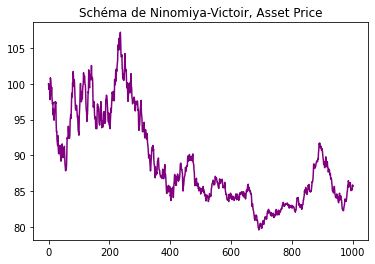

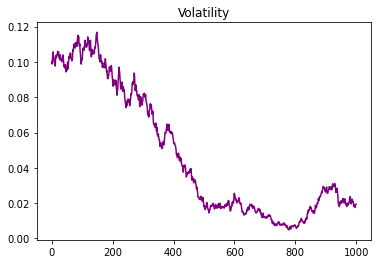

In [11]:
plt.plot(stockNV,color='purple')
plt.title('Schéma de Ninomiya-Victoir, Asset Price')
plt.show()

plt.plot(volatilityNV,color='purple')
plt.title('Volatility')
plt.show()

### Call Pricing, Monte-Carlo Method

In [31]:
# Defining every parameter we need for this pricing experiment

horizon, spot, vol_spot = 1, 100, 0.05

rho, mu, xi, kappa, theta = 0.3, 0.1, 0.3, 0.1, 0.05

test_number_simulations = 10000
test_number_steps = 20

strike = 100

In [18]:
def call_value(x, strike):
    if x > strike:
        return(x - strike)
    else:
        return(0)

def call_estimate(number_simulations_, strike_, horizon_, spot_, vol_spot_,
                 rho_, mu_, xi_, kappa_, theta_, number_steps_):
    
    call_matrix = np.zeros([number_simulations_])
    modelMC = Heston(mu_, theta_, xi_, kappa_, rho_)
    
    discount_factor = np.exp( - mu_ * horizon)
    
    for i in range(number_simulations_):
        stock_price, vol_sample = modelMC.NV(horizon_, number_steps_, spot_, vol_spot_)
        
        call_val = call_value(stock_price[-1], strike_)
        
        call_matrix[i] = discount_factor * call_val
        
    return(call_matrix)

In [19]:
start_time = time.time()

call_estimation_matrix = call_estimate(test_number_simulations, strike, horizon, spot, vol_spot,
                 rho, mu, xi, kappa, theta, test_number_steps)

end_time = time.time()

In [20]:
ecart_type_call = np.std(call_estimation_matrix)
erreur_call = 1.96 * ecart_type_call / np.sqrt(test_number_simulations)
estimation_call = np.mean(call_estimation_matrix)
    
print("Call value = ",np.around(estimation_call, 5),'+/-', np.around(erreur_call, 5))

Call value =  13.26552 +/- 0.42314


### Variance Reduction, Put pricing

The purpose of this section is to show (empirically) that it is faster to price a call by pricing a put and deducing the call value using the call put parity

In [25]:
# arguments are listed with an underscore to make sure the function doesn't use previously defined parameters

def put_value(x, strike):
    if x < strike:
        return(strike - x)
    else:
        return(0)

def put_estimate(number_simulations_, strike_, horizon_, spot_, vol_spot_,
                 rho_, mu_, xi_, kappa_, theta_, number_steps_):
    
    put_matrix = np.zeros([number_simulations_])
    modelMC = Heston(mu_, theta_, xi_, kappa_, rho_)
    
    discount_factor = np.exp( - mu_ * horizon)
    
    for i in range(number_simulations_):
        stock_price, vol_sample = modelMC.NV(horizon_, number_steps_, spot_, vol_spot_)
        
        put_val = put_value(stock_price[-1], strike_)
        
        put_matrix[i] = discount_factor * put_val
        
    return(put_matrix)

In [26]:
put_estimation_matrix = put_estimate(test_number_simulations, strike, horizon, spot, vol_spot,
                 rho, mu, xi, kappa, theta, test_number_steps)

In [28]:
print("Standard deviation call : ",ecart_type_call)
print("Standard deviation put : ",ecart_type_put)

Standard deviation call :  21.588693652611788
Standard deviation put :  8.713926267691026


## Options Asiatique

On va pricer par une méthode de Monte-Carlo l'option asiatique, donc le payoff à l'échéance est donné par :

$(K - \underset{k}{min} S_{t_k})_+$

In [32]:
def PayoffAsiat(trajectory_, strike_):
    min_price = np.min(trajectory_)
    
    if strike_ > min_price:
        return(strike_ - min_price)
    else:
        return(0)

In [33]:
monte_carlo_simulations = 1000
strike = 100

In [34]:
def AsiatEstimate(monte_carlo_simulations_, strike_, horizon_, spot_, vol_spot_,
                  rho_, mu_, theta_, xi_, kappa_, number_steps_):
    
    option_value_list = []
    
    modelMC = Heston(mu_, theta_, xi_, kappa_, rho_)
    
    for k in range(monte_carlo_simulations_):
        stock_price, vol_sample = modelMC.NV(horizon_, number_steps_, spot_, vol_spot_)
        
        payoff = PayoffAsiat(stock_price, strike_)
        
        option_value_list.append(payoff)
        
    return(option_value_list)

In [35]:
asiat_option_sample = AsiatEstimate(monte_carlo_simulations, strike, horizon, spot, vol_spot,
                 rho, mu, theta, xi, kappa, test_number_steps)

In [36]:
ecart_type = np.std(asiat_option_sample)
erreur = 1.96 * ecart_type / np.sqrt(monte_carlo_simulations)    
estimation = np.mean(asiat_option_sample)
print("Strike =",strike)
print("Number of samples : ",monte_carlo_simulations)
print("")
print("Asiatic Option Price : ", estimation,'+-', erreur)

Strike = 100
Number of samples :  1000

Asiatic Option Price :  10.509895632037601 +- 0.6022292740604827


### Scheme Convergence

Using a technique that is not shown in this Notebook, we can demonstrate empirically the convergence of the Ninomiya-Victoir scheme. For detailled explanations, check the link in the introduction

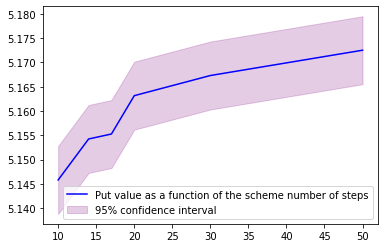

In [155]:
fig, ax = plt.subplots()
ax.plot(abs_, vect2, color='blue',label='Put value as a function of the scheme number of steps')
ax.fill_between(abs_, sup, inf, alpha=0.2, color='purple',label='95% confidence interval')
ax.legend(loc='lower right')